## 导入包

In [1]:
# 导入包

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, sampler
import torchvision
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pandas import Series
import cv2
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm import tqdm

import os, sys
import copy
import time
import itertools

print("包导入完成！")

包导入完成！


## 参数设置

In [2]:
# 顶级数据目录
DATA_DIR = "./input3/apto2019_preprocessed/"

# 两个csv文件名, 两个图片目录
TRAIN_CSV = "train_preprocessed.csv"
TEST_CSV = "test_preprocessed.csv"
TRAIN_DIR = "train_images_preprocessed/"
TEST_DIR = "test_images_preprocessed/"

# 图片格式
FORM = '.png'

# csv 文件列名
IMG_ID = 'id_code'    # 图片id
LABEL = 'diagnosis'  # 标签

# 从[resnet18, resnet34, resnet50]中选择模型
MODEL_NAME = "densenet"

# 模型目录
MODEL_DIR = "./models/"

# 我训练的模型名称
MY_MODEL_NAME = MODEL_NAME + "_model"

# 图片尺寸
IMG_SIZE = 224

# 分类数 (健康:0 / 患病:>0)
NUM_CLASSES = 2

# 随机种子
SEED = 77

# 训练集比例 train / (train + valid）
RATIO = 0.8

# 训练的批量大小（根据内存量而变化）
BATCH_SIZE = 64

# 训练的 epoch 数
NUM_EPOCHS = 20

# worker数
NUM_WORKERS = 8

# 用于特征提取的标志       当为False时，我们微调整个模型，当True时我们只更新重新形成的图层参数
FEATURE_EXTRACT = False

# 检测是否有可用的GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("参数设置完成！")

参数设置完成！


## 划分 `train.csv` 为 train set 和 validation set

In [3]:
df_train_and_valid = pd.read_csv(DATA_DIR + TRAIN_CSV) # train + validation

print("csv文件读取完成！")

csv文件读取完成！


看一下train.csv的内容

In [4]:
print(df_train_and_valid.info())
print(df_train_and_valid.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.3+ KB
None
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


对id_code进行操作

In [5]:
id_code = df_train_and_valid[IMG_ID]
id_code_np = Series(id_code).values

diagnosis = df_train_and_valid[LABEL]
diagnosis_np = Series(diagnosis).values

diagnosis = [i for i in diagnosis_np]
diagnosis = np.array(diagnosis)

# np.save(DATA_DIR+"image_name_train.npy", image_name_train)
# np.save(DATA_DIR+"image_name_valid.npy", image_name_valid)

对diagnosis进行操作

In [6]:
# 划分为训练集和验证集

image_name = [DATA_DIR+TRAIN_DIR+i+FORM for i in id_code_np]

ratio = RATIO # 训练集比例 train / (train + valid）
cut = int(id_code_np.shape[0] * ratio) # cut 为分隔位置

image_name_train = image_name[:cut]
image_name_valid = image_name[cut:]

diagnosis_train = diagnosis[:cut]
diagnosis_valid = diagnosis[cut:]

# np.save(DATA_DIR+"diagnosis_train.npy", diagnosis_train)
# np.save(DATA_DIR+"diagnosis_valid.npy", diagnosis_valid)

看一下训练集和验证集的数据分布

训练集图片数: 2929   训练集标签数: 2929 
验证集图片数: 733    验证集标签数: 733


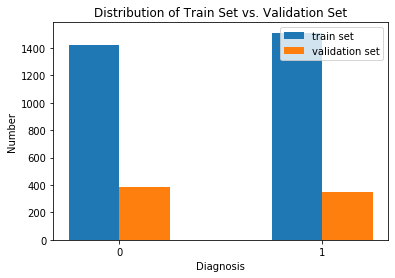

In [7]:
print("训练集图片数: {}   训练集标签数: {} \n验证集图片数: {}    验证集标签数: {}".format(
            len(image_name_train), len(diagnosis_train), len(image_name_valid), len(diagnosis_valid)))
label = 0, 1
diag_train_list, diag_valid_list = diagnosis_train.view().tolist(), diagnosis_valid.view().tolist()
train_cnt = diag_train_list.count(0), diag_train_list.count(1)+diag_train_list.count(2)+diag_train_list.count(3)+diag_train_list.count(4)
valid_cnt = diag_valid_list.count(0), diag_valid_list.count(1)+diag_valid_list.count(2)+diag_valid_list.count(3)+diag_valid_list.count(4)

ind = np.arange(len(train_cnt)) 
width = 0.25 

fig, ax = plt.subplots()
plt.title("Distribution of Train Set vs. Validation Set")
plt.xlabel('Diagnosis')
plt.ylabel('Number')
ax.bar(ind - width/2, train_cnt, width, label='train set')
ax.bar(ind + width/2, valid_cnt, width, label='validation set')
plt.xticks(ind, label)
plt.legend()

## 定义sampler

可以看到`diagnosis=0`和`diagnosis=1`两个类别的数据量相差很多，即类别不平衡

`sampler.WeightedRandomSampler`可以解决类别不平衡问题

In [8]:
def make_weights():                        
    wt0 = train_cnt[0]/(train_cnt[0]+train_cnt[1]) # diagnosis=0 所占总数比例
    wt1 = train_cnt[1]/(train_cnt[0]+train_cnt[1]) # diagnosis=1 所占总数比例
    wt0 = 1./wt0 # 反比
    wt1 = 1./wt1
    weight = [wt0, wt1]
    return weight

weights = make_weights()
class_weights = torch.FloatTensor(weights)

## 模型训练和验证函数

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False): 
    
    # 计算开始时间
    since = time.time()
    
    # 记录验证准确率，用于最后的plot分析
    val_acc_history = []
    
    # 记录所有的预测标签和真实标签，用于绘制Confusion matrix
    all_preds = torch.FloatTensor([]).cuda()
    all_labels = torch.FloatTensor([]).cuda()

    # 记录最佳模型
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print("Start training!")
    print('-' * 15 + '\n')
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'valid']:
            if phase == 'train':
                print("Training...")
                model.train()  # Set model to training mode
            else:
                print("Validating...")
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # 参数梯度归零
                optimizer.zero_grad()

                # 前向传播
                # 如果在训练时则跟踪轨迹
                with torch.set_grad_enabled(phase == 'train'):
                    # 获取模型输出并计算损失
                    # 开始的特殊情况，因为在inception模型的训练中它有一个辅助输出
                    # 在训练模式下，我们通过将最终输出和辅助输出相加来计算损失
                    # 但在测试中我们只考虑最终输出
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    

                    # 只在训练时反向传播 + 优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计loss和accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'valid' and epoch == (num_epochs-1):
                    all_preds = torch.cat((all_preds,preds.float()), dim=0)
                    all_labels = torch.cat((all_labels,labels.float()), dim=0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}     Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 记录最佳模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print() # 空一行打印

    # 计算所用时间
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    return model, val_acc_history, all_preds, all_labels


## 设置模型参数的.requires_grad属性

如果进行特征提取，此辅助函数将模型中参数的 `.requires_grad` 属性设置为False；

如果从头开始训练或微调，`.requires_grad` 属性设置为True，默认情况下也为True

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## 模型重塑（初始化）函数

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 初始化将在此if语句中设置的这些变量。 
    # 每个变量都是模型特定的。
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18"""
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet34":
        """ Resnet34"""
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50"""
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet"""
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn"""
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet"""
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet"""
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "inception":
        """ Inception v3
         Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # 处理辅助网络
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # 处理主要网络
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("无效的模型名字，正在退出...")
        exit()

    return model_ft, input_size


## 实例化模型

In [12]:
# 初始化模型
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, FEATURE_EXTRACT, use_pretrained=True)

# 打印刚刚实例化的模型
# print(model_ft)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/mist/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 16.3MB/s]


## 图片预处理

定义 transforms

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize([input_size, input_size]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transforms = transforms.Compose([
    transforms.Resize([input_size, input_size]),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

预处理

In [14]:
# Circle Crop 函数
def crop_image_from_gray(img, tol=7):
    # tol为tolerance
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            
            img = np.stack([img1,img2,img3], axis=-1)
        return img

In [15]:
# 单张图片预处理
def single_img_preprocess(img, sigmaX=10): 
    # PIL.Image 转换成 OpenCV 格式
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
    # circle crop（此过程转为非原色）
    img = crop_image_from_gray(img)    
    # 变回原色
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    # (x,y) 为图片中心,  r 为半径
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1) # thickness=-1 表示无厚度
    img = cv2.bitwise_and(img, img, mask=circle_img) # 按位与， 留白去黑
    img = crop_image_from_gray(img)
    
    # 高斯滤波
    img=cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4 , 128)
    
    img = cv2.resize(img, (input_size, input_size))
    
    return img 

In [16]:
# 图片处理整合成 loader
def img_loader(img_path, transforms):
    img_pil = Image.open(img_path)
    
#     img_np = single_img_preprocess(img_pil)
#     img_pil = Image.fromarray(img_np)
    
    img_tensor = transforms(img_pil)
    
    return img_tensor

看一张预处理效果

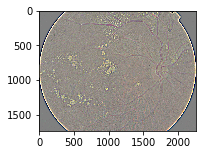

In [17]:
# test

height, width = IMG_SIZE, IMG_SIZE
SCALE = 1
dpi = 80 
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

path = "./input3/apto2019_preprocessed/train_images_preprocessed/0c917c372572.png" # lower-right, can be class3
image = Image.open(path)

fig = plt.figure(figsize=figsize)
plt.imshow(image)


## 自定义数据集类

In [18]:
class RetinaImageDataset(Dataset):
    """
    Args:
        img_path (string): 图像文件路径
        transforms: transform 操作
        loader: 单张图片文件处理(打开图片，预处理)
    """
    def __init__(self, img_path, diagnosis, transforms=None, loader=img_loader):
        # 图片的文件名
        self.img_path = img_path
        # 图片的标签（0~4）
        self.diagnosis = diagnosis
        # transform
        self.transforms = transforms
        # 单张图片文件处理
        self.loader = loader
        # 计算 length
        self.data_len = len(self.img_path)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, index):
        # 得到单张图片路径
        single_img_path = self.img_path[index]
        # 单张图片文件处理 (返回图片为tensor类型)
        single_image = self.loader(single_img_path, self.transforms)
        # 得到单张图片的 label
        single_diagnosis = 1 if self.diagnosis[index] > 0 else 0
    
        return (single_image, single_diagnosis)

定义训练集和验证集，并整合成一个字典

In [19]:
train_dataset = RetinaImageDataset(image_name_train, diagnosis_train, transforms=train_transforms)

valid_dataset = RetinaImageDataset(image_name_valid, diagnosis_valid, transforms=valid_transforms)

image_datasets = {'train': train_dataset, 'valid': valid_dataset}

dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) 
                        for x in ['train', 'valid']}

## 创建优化器

In [20]:
# 将模型发送到device
model_ft = model_ft.to(DEVICE)

# 收集要优化/更新的参数。如果正在进行微调，将更新所有参数；如果正在进行特征提取，只更新刚刚初始化的参数，即`requires_grad`参数为True。
params_to_update = model_ft.parameters()
print("待学习的参数: ")
if FEATURE_EXTRACT:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# 定义优化器
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

print()
print("optimizer定义完成！")

待学习的参数: 
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.denseblock

## 损失函数

In [21]:
# 设置损失函数
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())

print("loss function定义完成！")

loss function定义完成！


## 进行训练和验证

In [22]:
# 训练并验证

model_ft, hist, all_preds, all_labels = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 
                             num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

  0%|          | 0/46 [00:00<?, ?it/s]

Start training!
---------------

Epoch 1/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.2730     Acc: 0.8976
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1679     Acc: 0.9577

Epoch 2/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.1091     Acc: 0.9662
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1231     Acc: 0.9618

Epoch 3/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0834     Acc: 0.9730
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1062     Acc: 0.9632

Epoch 4/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0530     Acc: 0.9819
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0974     Acc: 0.9659

Epoch 5/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0407     Acc: 0.9877
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0988     Acc: 0.9659

Epoch 6/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0304     Acc: 0.9911
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0947     Acc: 0.9659

Epoch 7/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0260     Acc: 0.9932
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0889     Acc: 0.9686

Epoch 8/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0175     Acc: 0.9966
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0930     Acc: 0.9673

Epoch 9/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0166     Acc: 0.9959
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0860     Acc: 0.9714

Epoch 10/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0143     Acc: 0.9976
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0857     Acc: 0.9727

Epoch 11/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0133     Acc: 0.9969
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0927     Acc: 0.9714

Epoch 12/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0090     Acc: 0.9983
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0925     Acc: 0.9714

Epoch 13/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0087     Acc: 0.9983
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0918     Acc: 0.9741

Epoch 14/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0073     Acc: 0.9980
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0957     Acc: 0.9700

Epoch 15/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0120     Acc: 0.9966
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0936     Acc: 0.9727

Epoch 16/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0078     Acc: 0.9990
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1058     Acc: 0.9686

Epoch 17/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0034     Acc: 0.9997
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.0994     Acc: 0.9727

Epoch 18/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0051     Acc: 0.9990
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1044     Acc: 0.9700

Epoch 19/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0057     Acc: 0.9986
Validating...


  0%|          | 0/46 [00:00<?, ?it/s]

valid Loss: 0.1072     Acc: 0.9686

Epoch 20/20
----------
Training...


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.0064     Acc: 0.9983
Validating...


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]

valid Loss: 0.1058     Acc: 0.9686

Training complete in 20m 26s
Best val Acc: 0.974079


## 保存模型

In [23]:
torch.save(model_ft, MODEL_DIR + MY_MODEL_NAME + '.pth')  # 直接保存模型

## 可视化学习效果

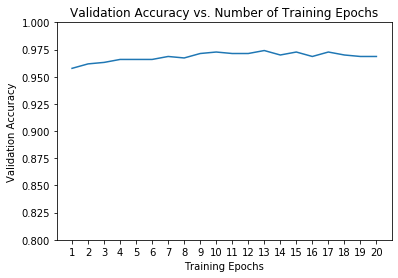

In [24]:
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, NUM_EPOCHS+1), ohist)
plt.ylim((0.8, 1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
# plt.legend()
plt.show()

## 混淆矩阵

In [25]:
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=45)
    plt.yticks(xlocations, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), verticalalignment="center", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [26]:
all_labels = all_labels.data.cpu().numpy()
all_preds = all_preds.data.cpu().numpy()

In [27]:
cm = confusion_matrix(all_labels, all_preds)

print(type(cm))

print(cm)

<class 'numpy.ndarray'>
[[379   8]
 [ 15 331]]


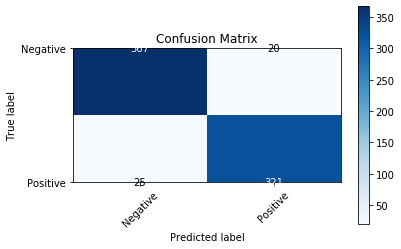

In [168]:
# diagnosis = ('Negative','Positive')
# plt.figure(figsize=(6,4))
# plot_confusion_matrix(cm, diagnosis)

## 加载模型，预测一张图片

In [82]:
def predict(img_path):
    model = torch.load(MODEL_DIR + MY_MODEL_NAME + '.pth')  # 直接加载模型
    model.eval()
    model = model.to(DEVICE)
    
    img_pil = Image.open(img_path)
    img_tensor = valid_transforms(img_pil)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(DEVICE)
    
    output = model(img_tensor)
    _, predict = torch.max(output, 1)
    
    return predict


预测为: tensor([0], device='cuda:0')


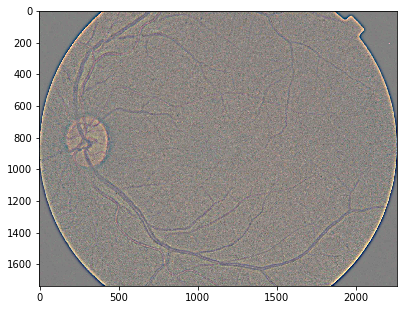

In [83]:
TEST_IMG = DATA_DIR + TEST_DIR + "0edc0c33e929" + FORM
pred = predict(img_path=TEST_IMG)
print("\n预测为: {}".format(pred))


img = Image.open(TEST_IMG)

height, width = 512, 512
SCALE=1
dpi = 80 # inch
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE
fig = plt.figure(figsize=figsize)
plt.imshow(img)

In [84]:
######################################################################################test

In [85]:
output = torch.randn(1, 2, 4, 4)
pred = torch.argmax(output, 1)
target = torch.empty(1, 4, 4, dtype=torch.long).random_(2)
confusion_matrix(pred.view(-1), target.view(-1))

array([[6, 4],
       [4, 2]])

In [86]:
output

tensor([[[[ 0.6294,  0.3526,  0.5055,  0.8779],
          [ 0.9602,  0.1693,  0.3458, -0.3056],
          [ 2.4027,  1.4650,  1.3549,  1.7753],
          [ 2.1638,  0.1395, -2.8205,  0.6116]],

         [[ 0.4048,  0.5225,  0.9604,  0.1314],
          [ 0.1186,  1.7393,  0.6161, -2.5929],
          [-0.5975,  1.0551,  0.6208, -0.4221],
          [-1.4954, -1.4370, -0.1624,  1.5371]]]])